## Transcrire un algorithme (Grover)

### Registres

In [1]:
from qiskit import QuantumRegister, ClassicalRegister

valeurs = QuantumRegister(3, 'valeurs')
mesures = ClassicalRegister(valeurs.size, 'mesures')

### Oracle

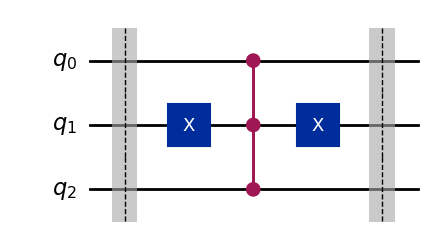

In [2]:
from qiskit import QuantumCircuit

oracle = QuantumCircuit(valeurs.size)
oracle.barrier(range(oracle.num_qubits))
oracle.x(1)
oracle.ccz(0, 1, 2)
oracle.x(1)
oracle.barrier(range(oracle.num_qubits))
oracle.draw('mpl')

### Diffuseur

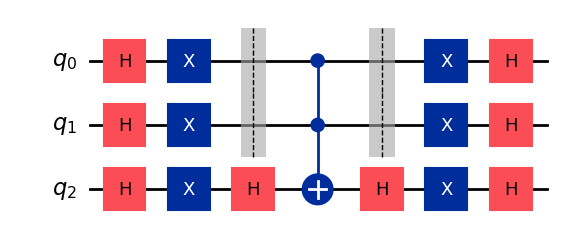

In [3]:
diffuseur = QuantumCircuit(valeurs.size)
diffuseur.h(range(diffuseur.num_qubits))
diffuseur.x(range(diffuseur.num_qubits))
diffuseur.barrier(range(diffuseur.num_qubits-1))
diffuseur.h(diffuseur.num_qubits-1)
diffuseur.ccx(0, 1, 2)
diffuseur.h(diffuseur.num_qubits-1)
diffuseur.barrier(range(diffuseur.num_qubits-1))
diffuseur.x(range(diffuseur.num_qubits))
diffuseur.h(range(diffuseur.num_qubits))
diffuseur.draw('mpl')

### Circuit

#### Amorce
Portes d'Hadamard + Oracle

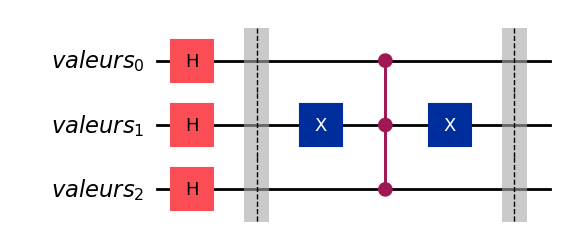

In [5]:
circuit = QuantumCircuit(valeurs)
circuit.h(range(circuit.num_qubits))
circuit = circuit.compose(oracle)
circuit.draw('mpl')

#### Vérification de l'oracle
Simulation partielle

In [7]:
from qiskit import transpile
from qiskit_aer import Aer

simulator = Aer.get_backend('statevector_simulator')
result = simulator.run(transpile(circuit, simulator), shots=256).result()
states = result.get_statevector(circuit)
states


Statevector([ 0.35355339+0.00000000e+00j,  0.35355339-4.32978028e-17j,
              0.35355339+0.00000000e+00j,  0.35355339+0.00000000e+00j,
              0.35355339-4.32978028e-17j, -0.35355339+8.65956056e-17j,
              0.35355339-4.32978028e-17j,  0.35355339-4.32978028e-17j],
            dims=(2, 2, 2))


Phases

In [10]:
from numpy import arctan2, degrees, round

[round(degrees(arctan2(state.imag, state.real))) for state in states]

/tmp/ipykernel_47584/2097038049.py:3: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  [round(degrees(arctan2(state.imag, state.real))) for state in states]


[0.0, -0.0, 0.0, 0.0, -0.0, 180.0, -0.0, -0.0]

Graphique

In [ ]:
from qiskit.visualization import plot_state_qsphere

plot_state_qsphere(states, show_state_phases=True)

#### Ajout du diffuseur

In [ ]:
circuit.compose(diffuseur, inplace=True)
circuit.draw()

#### Répétition + Mesure

In [ ]:
circuit = circuit \
    .compose(oracle) \
    .compose(diffuseur)

circuit.add_register(mesures)
circuit.measure_all(add_bits=False)
circuit.draw()

### Simulation

In [ ]:
from qiskit import transpile, BasicAer
from qiskit.visualization import plot_histogram

simulator = BasicAer.get_backend('qasm_simulator')
compiled = transpile(circuit, simulator)
job = simulator.run(compiled, shots=1000)
result = job.result()

counts = result.get_counts(compiled).int_outcomes()
plot_histogram(counts)